In [1]:
import os
import pandas as pd
import librosa
from pathlib import Path
from tqdm import tqdm

In [2]:
# torchaudioÍ∞Ä Ìó§ÎçîÎßå ÏùΩÏñ¥ duration Í≥ÑÏÇ∞Ìï¥ÏÑú Îπ†Î¶Ñ (Ï†ÑÏ≤¥ ÌååÌòï ÎîîÏΩîÎî© X)
import torchaudio

In [3]:
# === Î£®Ìä∏ Í≤ΩÎ°ú (Ï†ïÏ†ïÌïòÏã† Ï†àÎåÄÍ≤ΩÎ°ú) ===
ROOT = Path(r"D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞êÏ†ïÎ∂ÑÎ•òÎåÄÌôîÏùåÏÑ±\Í∞êÏ†ï Î∂ÑÎ•òÎ•º ÏúÑÌïú ÎåÄÌôî ÏùåÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖã")
PARTS = ["4Ï∞®", "5Ï∞®", "5_2Ï∞®"]  # ÌïòÏúÑ Ìè¥ÎçîÎ™Ö

In [4]:
def try_read_csv(csv_path: Path) -> pd.DataFrame:
    """Íµ¨Î∂ÑÏûê/Ïù∏ÏΩîÎî© ÏûêÎèô Í∞êÏßÄ ÏãúÎèÑ."""
    # sep=None + engine='python' -> Íµ¨Î∂ÑÏûê Ï∂îÏ†ï
    encodings = ["utf-8-sig", "cp949", "euc-kr"]
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(csv_path, sep=None, engine="python", encoding=enc)
        except Exception as e:
            last_err = e
    raise last_err

In [5]:
def get_duration_fast(wav_path: Path):
    """torchaudio.infoÎ°ú Îπ†Î•¥Í≤å Ïû¨ÏÉùÏãúÍ∞Ñ(Ï¥à) Í≥ÑÏÇ∞. Ïã§Ìå® Ïãú None."""
    try:
        info = torchaudio.info(str(wav_path))
        # num_frames / sample_rate = seconds
        return float(info.num_frames) / float(info.sample_rate)
    except Exception:
        return None

In [6]:
def load_one_part(part_name: str) -> pd.DataFrame:
    """Ìïú ÌååÌä∏(Ïòà: 4Ï∞®) CSV Î°úÎìú ‚Üí wav Ï†àÎåÄÍ≤ΩÎ°ú Î∂ôÏù¥Í≥† duration Í≥ÑÏÇ∞."""
    part_dir = ROOT / part_name

    # CSV ÌååÏùº Ï∞æÍ∏∞ (ÌååÏùºÎ™ÖÏù¥ Ï†ïÌï¥Ï†∏ ÏûàÏßÄ ÏïäÏùÑ Ïàò ÏûàÏúºÎØÄÎ°ú *.csv 1Í∞ú ÏÑ†ÌÉù)
    csv_candidates = list(part_dir.glob("*.csv"))
    if not csv_candidates:
        raise FileNotFoundError(f"[{part_name}] CSVÎ•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§: {part_dir}")
    csv_path = csv_candidates[0]  # ÌïÑÏöîÌïòÎ©¥ Í∑úÏπôÏóê ÎßûÏ∂∞ ÏÑ†ÌÉù Î°úÏßÅ Ï∂îÍ∞Ä

    df = try_read_csv(csv_path)

    # ÌïÑÏàò Ïª¨Îüº ÌôïÏù∏
    if "wav_id" not in df.columns:
        raise KeyError(f"[{part_name}] CSVÏóê 'wav_id' Ïª¨ÎüºÏù¥ ÏóÜÏäµÎãàÎã§. Ïã§Ï†ú Ïª¨ÎüºÎì§: {list(df.columns)}")

    # Ï†àÎåÄÍ≤ΩÎ°ú ÏÉùÏÑ±
    df["wav_path"] = df["wav_id"].astype(str).apply(lambda x: str(part_dir / f"{x}.wav"))

    # ÌååÏùº Ï°¥Ïû¨ Ïó¨Î∂Ä/Ïú†Ïã§ Ï≤¥ÌÅ¨
    df["wav_exists"] = df["wav_path"].apply(lambda p: os.path.exists(p))

    # duration Í≥ÑÏÇ∞ (Ï°¥Ïû¨ÌïòÎäî ÌååÏùºÎßå)
    durations = []
    for p in tqdm(df["wav_path"], desc=f"duration: {part_name}"):
        durations.append(get_duration_fast(Path(p)))
    df["duration"] = durations

    df["dataset_part"] = part_name
    return df

In [7]:
# === Ï†ÑÏ≤¥ Î≥ëÌï© ===
dfs = [load_one_part(p) for p in PARTS]
full_df = pd.concat(dfs, ignore_index=True)

duration: 5_2Ï∞®: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19374/19374 [00:25<00:00, 762.24it/s]


In [8]:
# Í∞ÑÎã® Î¨¥Í≤∞ÏÑ± Î°úÍ∑∏
missing = (~full_df["wav_exists"]).sum()
print(f"Ï¥ù {len(full_df):,}Ìñâ / Ïò§ÎîîÏò§ ÏóÜÏùå {missing:,}Ìñâ")

Ï¥ù 43,991Ìñâ / Ïò§ÎîîÏò§ ÏóÜÏùå 16Ìñâ


In [9]:
full_df.columns

Index(['wav_id', 'Î∞úÌôîÎ¨∏', 'ÏÉÅÌô©', '1Î≤à Í∞êÏ†ï', '1Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '2Î≤à Í∞êÏ†ï', '2Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '3Î≤à Í∞êÏ†ï',
       '3Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '4Î≤à Í∞êÏ†ï', '4Î≤àÍ∞êÏ†ïÏÑ∏Í∏∞', '5Î≤à Í∞êÏ†ï', '5Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', 'ÎÇòÏù¥', 'ÏÑ±Î≥Ñ',
       'wav_path', 'wav_exists', 'duration', 'dataset_part'],
      dtype='object')

In [10]:
# ÍµêÏ†ï ÎåÄÏÉÅ: '4Î≤àÍ∞êÏ†ïÏÑ∏Í∏∞' ‚Üí '4Î≤à Í∞êÏ†ïÏÑ∏Í∏∞'
full_df = full_df.rename(columns={"4Î≤àÍ∞êÏ†ïÏÑ∏Í∏∞": "4Î≤à Í∞êÏ†ïÏÑ∏Í∏∞"})

In [11]:
full_df.columns

Index(['wav_id', 'Î∞úÌôîÎ¨∏', 'ÏÉÅÌô©', '1Î≤à Í∞êÏ†ï', '1Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '2Î≤à Í∞êÏ†ï', '2Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '3Î≤à Í∞êÏ†ï',
       '3Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '4Î≤à Í∞êÏ†ï', '4Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '5Î≤à Í∞êÏ†ï', '5Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', 'ÎÇòÏù¥', 'ÏÑ±Î≥Ñ',
       'wav_path', 'wav_exists', 'duration', 'dataset_part'],
      dtype='object')

In [12]:
label_map = {
    "Sadness": "sad",
    "Angry": "angry",
    "Disgust": "disgust",
    "Fear": "fear",
    "Neutral": "neutral",
    "Happiness": "happiness",
    "Surprise": "surprise",
    # ÏÜåÎ¨∏ÏûêÎ°ú Îì§Ïñ¥Ïò® Í≤ÉÎèÑ ÎßûÏ∂§
    "sad": "sad", "anger": "angry", "disgust": "disgust", "fear": "fear",
    "neutral": "neutral", "happiness": "happiness", "surprise": "surprise",

    "sadness": "sad",
    "anger": "angry",
    "angry": "angry",
    "disgust": "disgust",
    "fear": "fear",
    "neutral": "neutral",
    "happiness": "happiness",
    "surprise": "surprise"
}

# annotator 5Î™Ö Í∞êÏ†ï Î™®Îëê ÌëúÏ§ÄÌôî
for i in range(1, 6):
    col = f"{i}Î≤à Í∞êÏ†ï"
    full_df[col] = full_df[col].map(label_map)
# df['final_emotion'] = df['final_emotion'].map(label_map).fillna(df['final_emotion'])
full_df['ÏÉÅÌô©'] = full_df['ÏÉÅÌô©'].map(label_map).fillna(full_df['ÏÉÅÌô©'])

In [13]:
full_df.columns

Index(['wav_id', 'Î∞úÌôîÎ¨∏', 'ÏÉÅÌô©', '1Î≤à Í∞êÏ†ï', '1Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '2Î≤à Í∞êÏ†ï', '2Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '3Î≤à Í∞êÏ†ï',
       '3Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '4Î≤à Í∞êÏ†ï', '4Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '5Î≤à Í∞êÏ†ï', '5Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', 'ÎÇòÏù¥', 'ÏÑ±Î≥Ñ',
       'wav_path', 'wav_exists', 'duration', 'dataset_part'],
      dtype='object')

In [14]:
full_df.iloc[:,2:13].value_counts()

ÏÉÅÌô©        1Î≤à Í∞êÏ†ï     1Î≤à Í∞êÏ†ïÏÑ∏Í∏∞  2Î≤à Í∞êÏ†ï     2Î≤à Í∞êÏ†ïÏÑ∏Í∏∞  3Î≤à Í∞êÏ†ï     3Î≤à Í∞êÏ†ïÏÑ∏Í∏∞  4Î≤à Í∞êÏ†ï     4Î≤à Í∞êÏ†ïÏÑ∏Í∏∞  5Î≤à Í∞êÏ†ï     5Î≤à Í∞êÏ†ïÏÑ∏Í∏∞
sad       sad       1        sad       1        sad       1        sad       1        sad       1          936
                                       2        sad       1        sad       1        sad       1          820
          neutral   0        sad       1        sad       1        sad       1        sad       1          611
          sad       1        sad       1        sad       1        sad       1        sad       2          449
                    2        sad       1        sad       1        sad       1        sad       1          439
                                                                                                          ... 
disgust   sad       1        neutral   0        neutral   0        angry     1        angry     1            1
                                   

In [15]:
full_df['5Î≤à Í∞êÏ†ï']

0          angry
1          angry
2          angry
3            sad
4            sad
          ...   
43986        sad
43987    neutral
43988        sad
43989        sad
43990    neutral
Name: 5Î≤à Í∞êÏ†ï, Length: 43991, dtype: object

In [16]:
from collections import Counter
import pandas as pd

def majority_vote_with_tie(row):
    # annotator ÎùºÎ≤® 5Í∞ú Î™®ÏúºÍ∏∞
    labels = [row[f"{i}Î≤à Í∞êÏ†ï"] for i in range(1, 6)]
    labels = [l for l in labels if pd.notna(l)]
    if not labels:
        return None
    
    cnt = Counter(labels)
    most_common = cnt.most_common()
    
    # ÏµúÎπàÍ∞í ÌõÑÎ≥¥Îì§
    top_count = most_common[0][1]
    candidates = [lab for lab, n in most_common if n == top_count]
    
    if len(candidates) == 1:
        return candidates[0]
    else:
        # ÎèôÎ•†Ïù∏ Í≤ΩÏö∞ ‚Üí placeholder
        return "TIE"

full_df["final_emotion"] = full_df.apply(majority_vote_with_tie, axis=1)

# ÎèôÎ•† Í±¥Ïàò ÌôïÏù∏
print("ÎèôÎ•† Î∞úÏÉù Í±¥Ïàò:", (full_df["final_emotion"] == "TIE").sum())


ÎèôÎ•† Î∞úÏÉù Í±¥Ïàò: 4788


In [17]:
from collections import Counter
import pandas as pd

def vote_with_situation(row):
    """
    return: (final_emotion, tie_initial(bool), tie_resolved_by_situation(bool))
    - tie_initial: Ïñ¥ÎÖ∏ÌÖåÏù¥ÌÑ∞ 5ÌëúÎßåÏúºÎ°ú ÎèôÎ•†Ïù¥ÏóàÎäîÏßÄ
    - tie_resolved_by_situation: ÏÉÅÌô© 1ÌëúÎ•º Ï∂îÍ∞ÄÌñàÎçîÎãà Ìï¥ÏÜåÎêòÏóàÎäîÏßÄ
    """
    # 1) Ïñ¥ÎÖ∏ÌÖåÏù¥ÌÑ∞ Ìëú ÏàòÏßë
    labels = [row.get(f"{i}Î≤à Í∞êÏ†ï") for i in range(1, 6)]
    labels = [l for l in labels if pd.notna(l)]

    if not labels:
        return (None, False, False)

    cnt = Counter(labels)
    mc = cnt.most_common()
    top = mc[0][1]
    top_cands = [lab for lab, n in mc if n == top]

    # 2) ÏµúÏ¥à Ìà¨ÌëúÏóêÏÑú Îã®Ïùº ÏµúÎã§ ÎìùÌëúÏûêÎ©¥ Ï¢ÖÎ£å
    if len(top_cands) == 1:
        return (top_cands[0], False, False)

    # 3) ÎèôÎ•†Ïù¥Î©¥ ÏÉÅÌô© 1Ìëú Ï∂îÍ∞Ä ÌõÑ Ïû¨Ìà¨Ìëú
    situation = row.get("ÏÉÅÌô©")
    tie_initial = True
    if pd.notna(situation):
        cnt_with_sit = Counter(labels + [situation])
        mc2 = cnt_with_sit.most_common()
        top2 = mc2[0][1]
        top2_cands = [lab for lab, n in mc2 if n == top2]
        if len(top2_cands) == 1:
            return (top2_cands[0], True, True)

    # 4) Ïó¨Ï†ÑÌûà ÎèôÎ•†Ïù¥Î©¥ TIEÎ°ú ÎÇ®ÍπÄ
    return ("TIE", tie_initial, False)

# Ï†ÅÏö©
full_df[["final_emotion", "tie_initial", "tie_resolved_by_situation"]] = (
    full_df.apply(vote_with_situation, axis=1, result_type="expand")
)


In [19]:
full_df[full_df['final_emotion']=="TIE"]

wav_id                        Î∞úÌôîÎ¨∏         ÏÉÅÌô©  \
57     5e29919c5807b852d9e01a66              Ïñ¥Ï†ú ÏßÄÏßÑ ÎÇú Í±∞ ÏïåÏïÑ?       fear   
134    5e2aeded5807b852d9e021d0              Ìïò, ÏñºÎ•∏ ÏûäÏñ¥Î≤ÑÎ†§ÏïºÏßÄ.    disgust   
183    5e2d20d65807b852d9e0250b                ÎãπÏó∞Ìûà ÏôÑÏ†Ñ ÎÜÄÎûêÏßÄ.    disgust   
288    5e2d912b5807b852d9e02674     ÏïÑÎãà, ÌïúÎã¨ Ï†ÑÏóê Ï£ºÏùò Ìïú Î≤àÎßå Ìï¥Î¥§Ïñ¥.      angry   
306    5e2d96d65807b852d9e026cc              Îã§ Ìè¨Í∏∞ ÌñàÏñ¥. Ïñ¥Ï©åÏßÄ?      angry   
...                         ...                        ...        ...   
43911  5fbe2402cb503578af9eecd6            ÏßÑÏßú ÎÑàÍ∞Ä Îã§ Îèà Ï§Ñ Í±∞Ïïº?  happiness   
43914  5fbe249d576e9378b67ad3df         ÏïÑÎãà, Í≥ÑÏÜç ÏßëÏóêÎßå ÏûàÏñ¥ÏïºÌïòÏûñÏïÑ.        sad   
43956  5fbe33d0576e9378b67ad4c9  Ïò§Îäò ÎßàÎùºÌÜ§ ÎåÄÌöåÎ•º ÎÇòÍ∞îÎäîÎç∞ Í∏∞Î°ùÏùÑ Í∞±Ïã†ÌñàÏñ¥!  happiness   
43965  5fbe2db6cb503578af9eed5e             ÏôÄ ÏßúÏû•Î©¥ÏóêÏÑú Î≤åÎ†àÎÇòÏôîÏñ¥.    disgust   
43968  5fbe2e5acb503578af9eed69         ÎÑàÎ¨¥ ÎÜÄÎùºÍ∞ÄÏßÄÍ≥† ÏÇ¨ÏßÑÎèÑ Î™ªÏ∞çÏóàÏñ¥.    disgust   

          1Î≤à Í∞êÏ†ï  1Î≤à Í∞êÏ†ïÏÑ∏Í∏∞      2Î≤à Í∞êÏ†ï  2Î≤à Í∞êÏ†ïÏÑ∏Í∏∞     3Î≤à Í∞êÏ†ï  3Î≤à Í∞êÏ†ïÏÑ∏Í∏∞     4Î≤à Í∞êÏ†ï  \
57     surprise        1   surprise        1      fear        1   neutral   
134       angry        1      angry        1   disgust        1   neutral   
183     disgust        1      angry        2     angry        1  surprise   
288       angry        1        sad        1   neutral        0   neutral   
306       angry        1        sad        1       sad        1   neutral   
...         ...      ...        ...      ...       ...      ...       ...   
43911   neutral        0      angry        1  surprise        2   neutral   
43914   disgust        1    disgust        1       sad        2     angry   
43956   neutral        0  happiness        1   neutral        0       sad   
43965       sad        1        sad        1   disgust        2   neutral   
43968       sad        1    disgust        1   neutral        0       sad   

       ...  5Î≤à Í∞êÏ†ïÏÑ∏Í∏∞  ÎÇòÏù¥      ÏÑ±Î≥Ñ  \
57     ...        0  29    male   
134    ...        0  29  female   
183    ...        1  32  female   
288    ...        1  30  female   
306    ...        0  30  female   
...    ...      ...  ..     ...   
43911  ...        1  24  female   
43914  ...        1  24  female   
43956  ...        1  23  female   
43965  ...        0  23  female   
43968  ...        0  23  female   

                                                wav_path wav_exists  duration  \
57     D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...       True  1.749333   
134    D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...       True  2.645333   
183    D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...       True  2.176000   
288    D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...       True  4.138667   
306    D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...       True  3.797333   
...                                                  ...        ...       ...   
43911  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...       True  2.944000   
43914  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...       True  5.461333   
43956  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...       True  5.632000   
43965  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...       True  3.797333   
43968  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...       True  3.370667   

       dataset_part  final_emotion tie_initial tie_resolved_by_situation  
57               4Ï∞®            TIE        True                     False  
134              4Ï∞®            TIE        True                     False  
183              4Ï∞®            TIE        True                     False  
288              4Ï∞®            TIE        True                     False 

In [20]:
# Í±¥Ïàò ÏöîÏïΩ
n_initial_ties = int(full_df["tie_initial"].sum())
n_resolved     = int(full_df["tie_resolved_by_situation"].sum())
n_remaining    = int((full_df["final_emotion"] == "TIE").sum())
n_total        = len(full_df)

print(f"Ï¥ù ÏÉòÌîå: {n_total:,}")
print(f"- ÏµúÏ¥à ÎèôÎ•†: {n_initial_ties:,}")
print(f"- ÏÉÅÌô© Ìà¨ÌëúÎ°ú Ìï¥ÏÜå: {n_resolved:,}")
print(f"- Ïó¨Ï†ÑÌûà ÎèôÎ•†(TIE): {n_remaining:,}")

# ÏµúÏ¢Ö ÎùºÎ≤® Î∂ÑÌè¨ (TIE Ìè¨Ìï®)
print("\n[final_emotion Î∂ÑÌè¨]")
print(full_df["final_emotion"].value_counts(dropna=False))

# (ÏòµÏÖò) ÏÉÅÌô© Ìà¨ÌëúÎ°ú Ìï¥ÏÜåÎêú ÌñâÎßåÏùò ÏÉÅÌô© vs ÏµúÏ¢Ö ÍµêÏ∞®Ìëú
resolved_mask = full_df["tie_resolved_by_situation"] == True
if resolved_mask.any():
    print("\n[ÏÉÅÌô© Ìà¨ÌëúÎ°ú Ìï¥ÏÜåÎêú ÏºÄÏù¥Ïä§: ÏÉÅÌô© vs final_emotion]")
    print(pd.crosstab(full_df.loc[resolved_mask, "ÏÉÅÌô©"],
                      full_df.loc[resolved_mask, "final_emotion"]))

# (ÏòµÏÖò) ÏïÑÏßÅ TIEÏù∏ ÏÉòÌîå Î™á Í∞ú Î≥¥Í∏∞
print("\n[TIE ÏÉòÌîå ÏòàÏãú 5Í∞ú]")
print(full_df.loc[full_df["final_emotion"] == "TIE",
                  ["wav_id", "ÏÉÅÌô©"] + [f"{i}Î≤à Í∞êÏ†ï" for i in range(1,6)]].head())


Ï¥ù ÏÉòÌîå: 43,991
- ÏµúÏ¥à ÎèôÎ•†: 4,788
- ÏÉÅÌô© Ìà¨ÌëúÎ°ú Ìï¥ÏÜå: 3,221
- Ïó¨Ï†ÑÌûà ÎèôÎ•†(TIE): 1,567

[final_emotion Î∂ÑÌè¨]
final_emotion
sad          16577
angry         8154
neutral       6891
happiness     3953
fear          2986
disgust       2715
TIE           1567
surprise      1148
Name: count, dtype: int64

[ÏÉÅÌô© Ìà¨ÌëúÎ°ú Ìï¥ÏÜåÎêú ÏºÄÏù¥Ïä§: ÏÉÅÌô© vs final_emotion]
final_emotion  angry  disgust  fear  happiness  neutral  sad  surprise
ÏÉÅÌô©                                                                    
angry            819        0     0          0        0    0         0
disgust            0      376     0          0        0    0         0
fear               0        0   398          0        0    0         0
happiness          0        0     0        352        0    0         0
neutral            0        0     0          0      627    0         0
sad                0        0     0          0        0  404         0
surprise           0        0     0      

In [21]:
full_df['ÏÉÅÌô©'].value_counts()

ÏÉÅÌô©
sad          14000
angry        11635
disgust       4660
happiness     4548
fear          4131
neutral       3262
surprise      1755
Name: count, dtype: int64

In [18]:
clean_df = full_df[full_df["final_emotion"] != "TIE"].copy()

In [19]:
clean_df["utter_len"] = clean_df["Î∞úÌôîÎ¨∏"].astype(str).apply(len)

In [20]:
from collections import Counter
import pandas as pd
import re

def ensure_agreement_ratio(df: pd.DataFrame,
                           final_col: str = "final_emotion",
                           k: int = 5) -> pd.DataFrame:
    """
    dfÏóê agreement Í¥ÄÎ†® Ïª¨ÎüºÏù¥ ÏóÜÏúºÎ©¥ ÏÉùÏÑ±Ìï¥ÏÑú Î∞òÌôò.
    - agreement_ratio = ÏµúÎã§ ÎìùÌëúÏàò / Ïú†Ìö®ÌëúÏàò
    - agreement_count = ÏµúÎã§ ÎìùÌëúÏàò
    - voters_count = Ïú†Ìö®ÌëúÏàò
    Ï£ºÏùò: annotator ÎùºÎ≤® Ïª¨ÎüºÎ™ÖÏùÄ '1Î≤à Í∞êÏ†ï' ~ '5Î≤à Í∞êÏ†ï' ÌòïÏãùÏù¥ÎùºÍ≥† Í∞ÄÏ†ï.
    """
    if "agreement_ratio" in df.columns and "agreement_count" in df.columns and "voters_count" in df.columns:
        return df  # Ïù¥ÎØ∏ ÏûàÏúºÎ©¥ Í∑∏ÎåÄÎ°ú Î∞òÌôò

    ann_cols = [f"{i}Î≤à Í∞êÏ†ï" for i in range(1, k+1)]
    # Ï°¥Ïû¨ÌïòÎäî Ïª¨ÎüºÎßå ÏÇ¨Ïö© (Ïò§ÌÉàÏûê/Í≤∞Ï∏° Ïª¨Îüº Î∞©Ïñ¥)
    ann_cols = [c for c in ann_cols if c in df.columns]

    def _agg(row):
        votes = [row.get(c) for c in ann_cols]
        votes = [v for v in votes if pd.notna(v)]
        if not votes:
            return pd.Series({"agreement_ratio": None, "agreement_count": 0, "voters_count": 0})
        cnt = Counter(votes)
        top = cnt.most_common(1)[0][1]
        voters = len(votes)
        return pd.Series({
            "agreement_ratio": top / voters if voters else None,
            "agreement_count": top,
            "voters_count": voters
        })

    out = df.apply(_agg, axis=1)
    for c in out.columns:
        df[c] = out[c]
    return df

clean_df = ensure_agreement_ratio(clean_df)


In [21]:
clean_df.columns

Index(['wav_id', 'Î∞úÌôîÎ¨∏', 'ÏÉÅÌô©', '1Î≤à Í∞êÏ†ï', '1Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '2Î≤à Í∞êÏ†ï', '2Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '3Î≤à Í∞êÏ†ï',
       '3Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '4Î≤à Í∞êÏ†ï', '4Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '5Î≤à Í∞êÏ†ï', '5Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', 'ÎÇòÏù¥', 'ÏÑ±Î≥Ñ',
       'wav_path', 'wav_exists', 'duration', 'dataset_part', 'final_emotion',
       'tie_initial', 'tie_resolved_by_situation', 'utter_len',
       'agreement_ratio', 'agreement_count', 'voters_count'],
      dtype='object')

üéß ÎûúÎç§ ÏÉòÌîå Í≤ΩÎ°ú:
 {'neutral': ['D:\\ex\\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\\AI_Dev_3rd_Project\\YEO\\datasets\\Í∞êÏ†ïÎ∂ÑÎ•òÎåÄÌôîÏùåÏÑ±\\Í∞êÏ†ï Î∂ÑÎ•òÎ•º ÏúÑÌïú ÎåÄÌôî ÏùåÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖã\\5_2Ï∞®\\5fb4b82444697678c497ab67.wav', 'D:\\ex\\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\\AI_Dev_3rd_Project\\YEO\\datasets\\Í∞êÏ†ïÎ∂ÑÎ•òÎåÄÌôîÏùåÏÑ±\\Í∞êÏ†ï Î∂ÑÎ•òÎ•º ÏúÑÌïú ÎåÄÌôî ÏùåÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖã\\5_2Ï∞®\\5f7087f0d338b948c4e68a3d.wav', 'D:\\ex\\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\\AI_Dev_3rd_Project\\YEO\\datasets\\Í∞êÏ†ïÎ∂ÑÎ•òÎåÄÌôîÏùåÏÑ±\\Í∞êÏ†ï Î∂ÑÎ•òÎ•º ÏúÑÌïú ÎåÄÌôî ÏùåÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖã\\5_2Ï∞®\\5fb4956fcb503578af9ed87e.wav', 'D:\\ex\\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\\AI_Dev_3rd_Project\\YEO\\datasets\\Í∞êÏ†ïÎ∂ÑÎ•òÎåÄÌôîÏùåÏÑ±\\Í∞êÏ†ï Î∂ÑÎ•òÎ•º ÏúÑÌïú ÎåÄÌôî ÏùåÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖã\\4Ï∞®\\5e45637a2a2d173b73a0298f.wav', 'D:\\ex\\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\\AI_Dev_3rd_Project\\YEO\\datasets\\Í∞êÏ†ïÎ∂ÑÎ•òÎåÄÌôîÏùåÏÑ±\\Í∞êÏ†ï Î∂ÑÎ•òÎ•º ÏúÑÌïú ÎåÄÌôî ÏùåÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖã\\5_2Ï∞®\\5f77eb249e04b149046cc09c.wav', 'D:\\ex\\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\\AI_Dev_3rd_Project\\YEO\\da

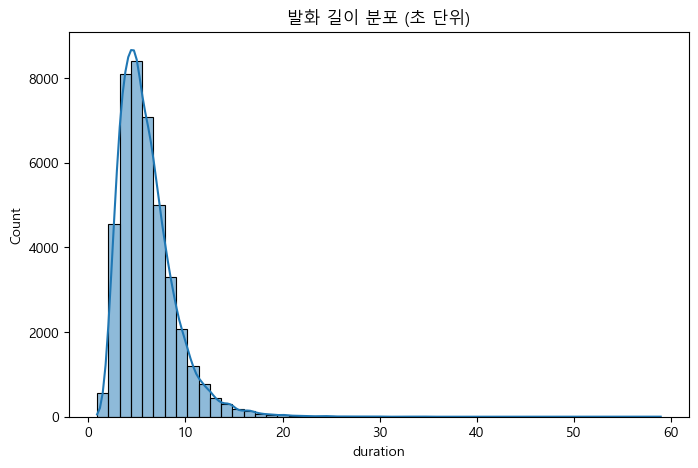

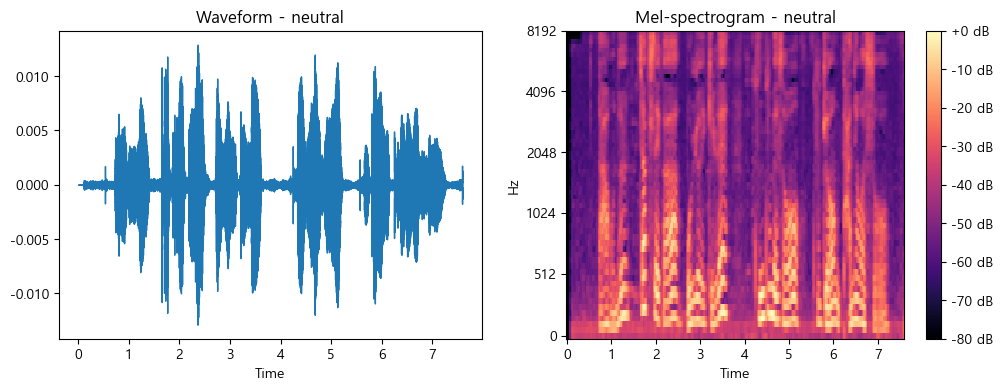

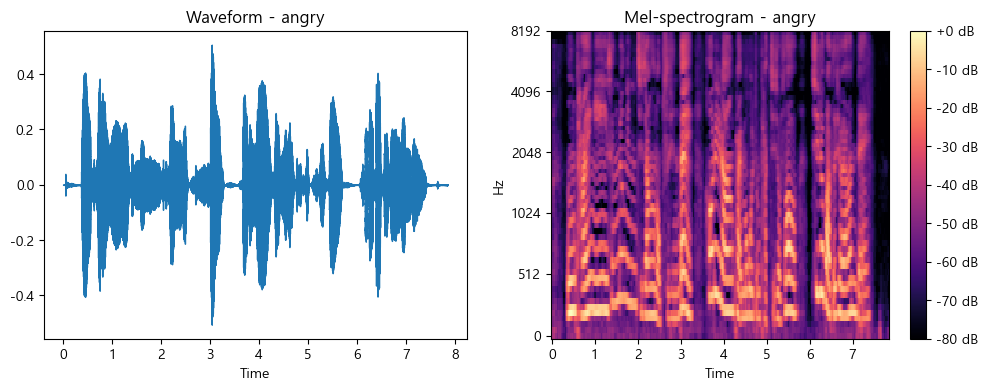

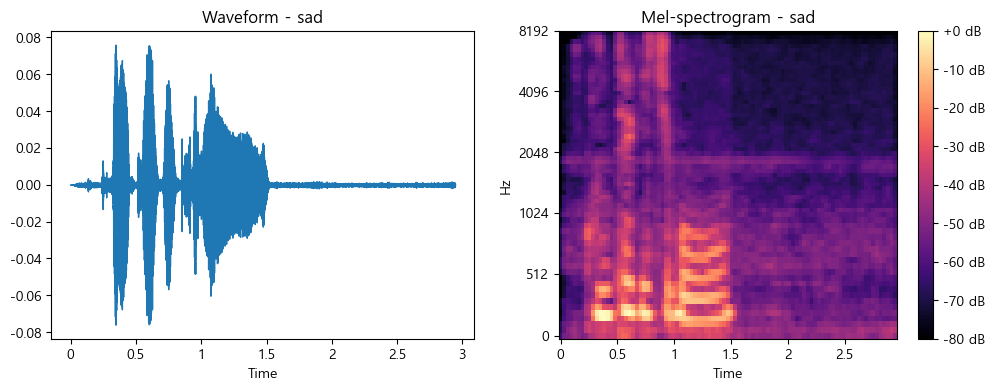

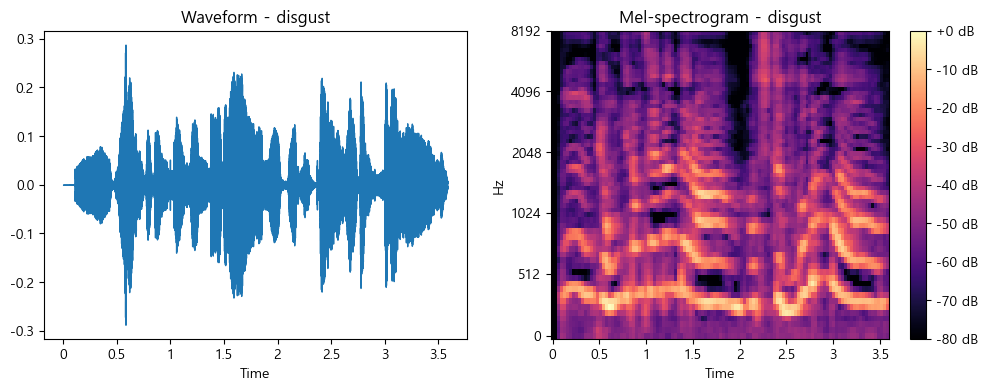

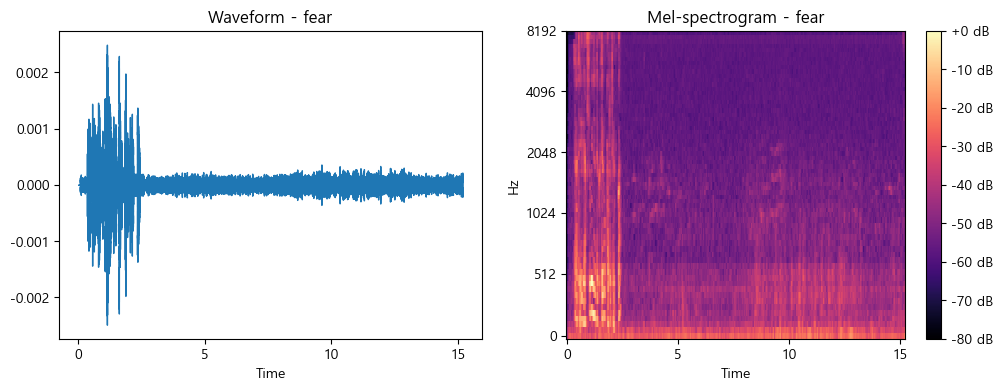

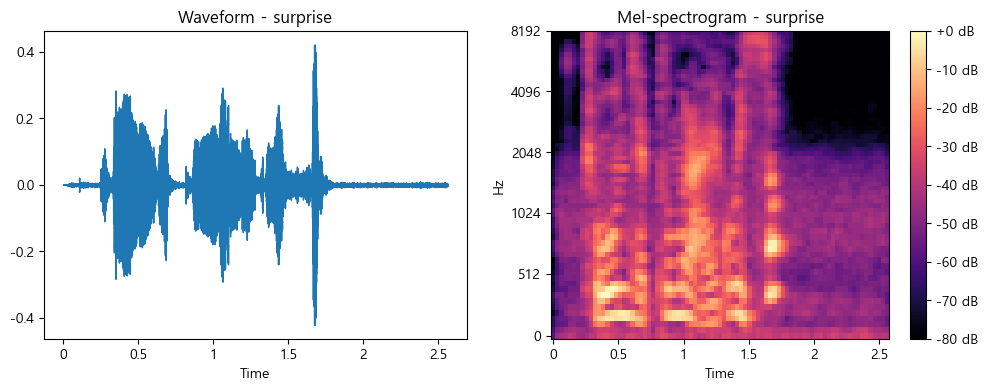

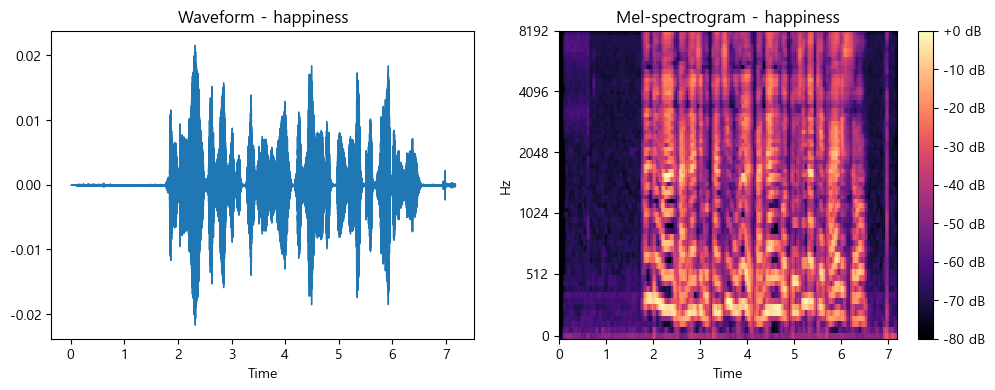

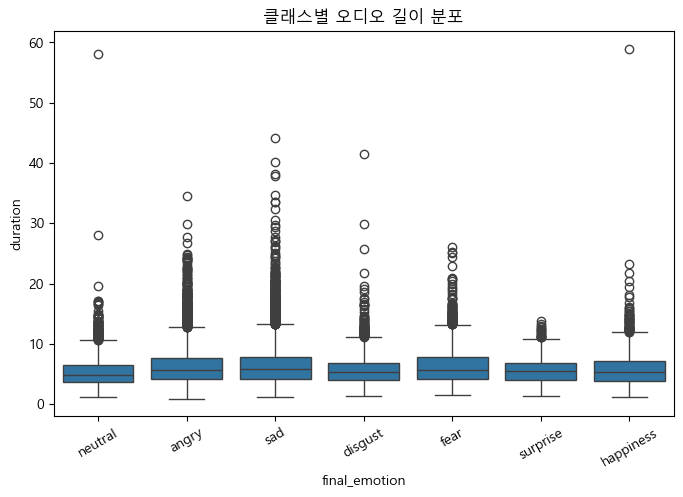

‚ö†Ô∏è agreement_ratio ÎÇÆÏùÄ ÏÉòÌîå ÏòàÏãú:
                          wav_id final_emotion  agreement_ratio
29030  5f6892ebd338b948c4e68379     happiness              0.4
39441  5fb8c952cb503578af9edced       disgust              0.4
27697  5f617c663bd6941613f6d534       neutral              0.4
30945  5f7079f9111dfd48d40fd38e         angry              0.4
2632   5e3559eb5807b852d9e081eb         angry              0.4
üîç Neutral/Surprise/Fear ÏÉòÌîå ÏòàÏãú:
                          wav_id final_emotion  agreement_ratio
37083  5fb33e4ee3dcec421f8357d7       neutral              1.0
37037  5fba1871cb503578af9ee05d       neutral              0.6
37867  5fb4d45c4c55eb78bd7cdb06       neutral              0.8
23778  5efabba78bbcd61f551d2bd9          fear              0.8
30720  5f6f371cd338b948c4e68954          fear              0.8


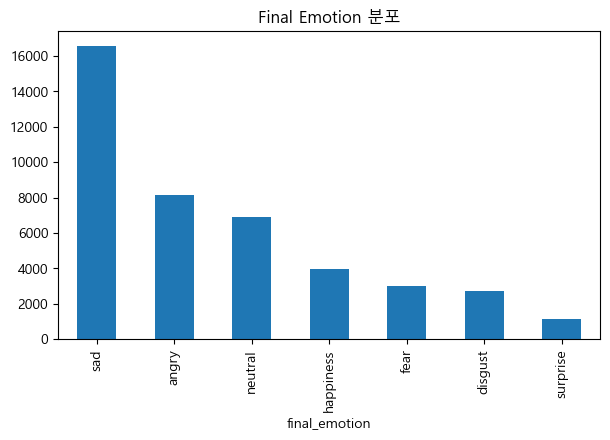

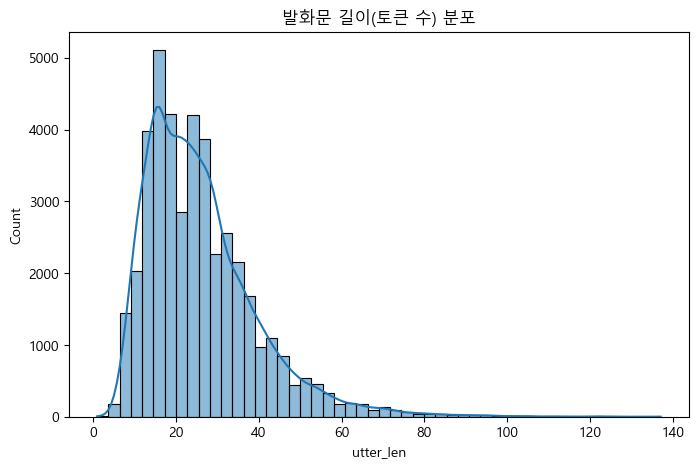

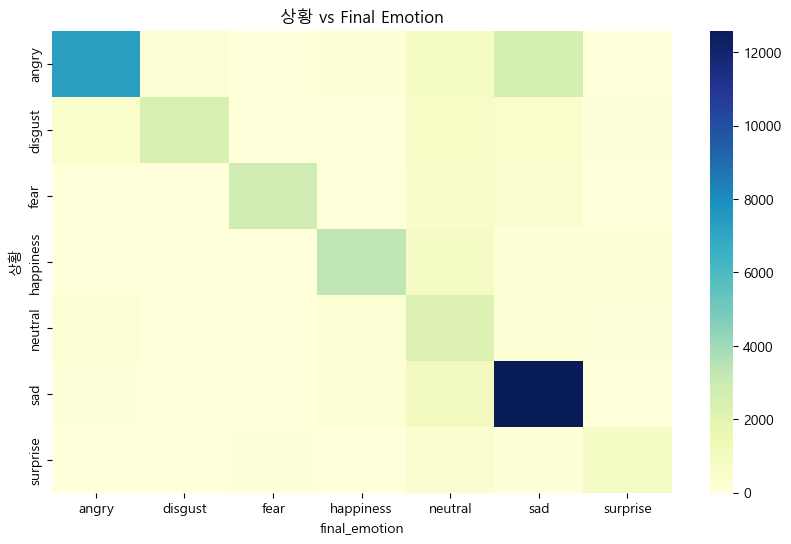

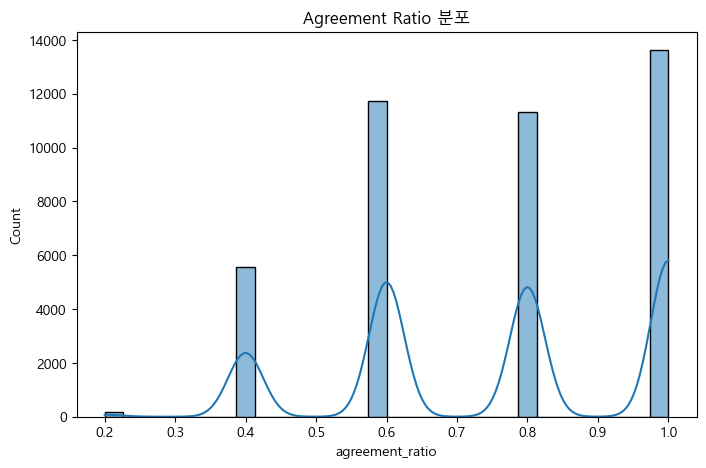

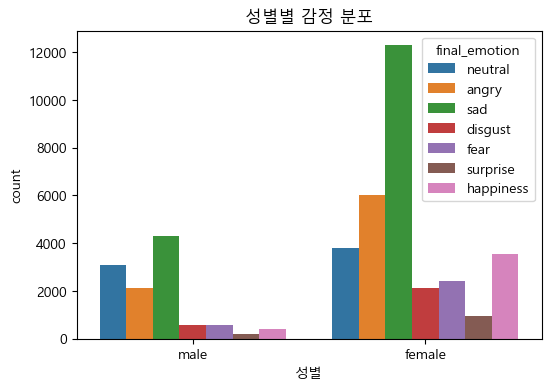

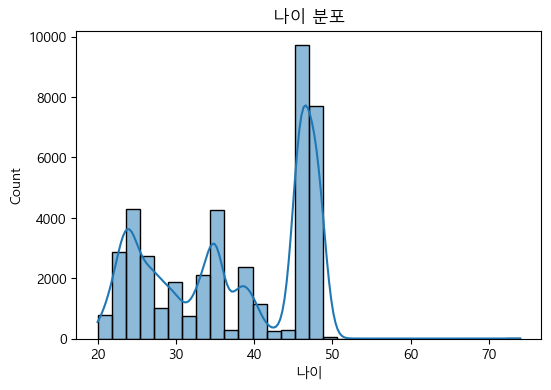

In [35]:
import os
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ====================================================
# A. ÏÉòÌîå ÏàòÏ§Ä ÌôïÏù∏
# ====================================================

# 1) ÌÅ¥ÎûòÏä§Î≥Ñ Ïò§ÎîîÏò§ ÏÉòÌîå 2~3Í∞ú ÌôïÏù∏
def play_random_samples(df, n=2):
    samples = {}
    for emo in df["final_emotion"].unique():
        subset = df[df["final_emotion"] == emo]
        if len(subset) > 0:
            samples[emo] = subset.sample(min(n, len(subset)))["wav_path"].tolist()
    return samples

sample_paths = play_random_samples(clean_df, n=200)
print("üéß ÎûúÎç§ ÏÉòÌîå Í≤ΩÎ°ú:\n", sample_paths)
# -> Ïó¨Í∏∞ÏÑú Ïã§Ï†ú Ï≤≠Ï∑®Îäî Ï£ºÌîºÌÑ∞/ÏΩúÎû© ÌôòÍ≤ΩÏóêÏÑú IPython.display.Audio ÏÇ¨Ïö© Í∞ÄÎä•

# 2) Î∞úÌôî Í∏∏Ïù¥ Î∂ÑÌè¨ (duration)
plt.figure(figsize=(8,5))
sns.histplot(clean_df["duration"], bins=50, kde=True)
plt.title("Î∞úÌôî Í∏∏Ïù¥ Î∂ÑÌè¨ (Ï¥à Îã®ÏúÑ)")
plt.show()

# ====================================================
# B. ÏãúÍ∞ÅÏ†Å ÌôïÏù∏
# ====================================================

# ÌÅ¥ÎûòÏä§Î≥Ñ waveplot & mel-spectrogram ÏãúÍ∞ÅÌôî
def plot_wave_mel(df, emotion):
    row = df[df["final_emotion"] == emotion].sample(1).iloc[0]
    y, sr = librosa.load(row["wav_path"], sr=16000)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform - {emotion}")
    
    plt.subplot(1,2,2)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.title(f"Mel-spectrogram - {emotion}")
    plt.colorbar(format="%+2.f dB")
    plt.show()

for emo in clean_df["final_emotion"].unique():
    plot_wave_mel(clean_df, emo)

# ÌÅ¥ÎûòÏä§Î≥Ñ ÌèâÍ∑† duration Î∂ÑÌè¨
plt.figure(figsize=(8,5))
sns.boxplot(x="final_emotion", y="duration", data=clean_df)
plt.title("ÌÅ¥ÎûòÏä§Î≥Ñ Ïò§ÎîîÏò§ Í∏∏Ïù¥ Î∂ÑÌè¨")
plt.xticks(rotation=30)
plt.show()

# ====================================================
# C. ÎùºÎ≤® ÌíàÏßà Ï†êÍ≤Ä
# ====================================================

# agreement_ratio ÎÇÆÏùÄ ÏÉòÌîå ÌôïÏù∏
low_agree = clean_df[clean_df["agreement_ratio"] < 0.6].sample(5)
print("‚ö†Ô∏è agreement_ratio ÎÇÆÏùÄ ÏÉòÌîå ÏòàÏãú:\n", low_agree[["wav_id", "final_emotion", "agreement_ratio"]])

# confusion ÎÜíÏùÄ Í∞êÏ†ïÏåç (neutral vs surprise, fear)
check_pairs = clean_df[clean_df["final_emotion"].isin(["neutral","surprise","fear"])]
print("üîç Neutral/Surprise/Fear ÏÉòÌîå ÏòàÏãú:\n", check_pairs.sample(5)[["wav_id","final_emotion","agreement_ratio"]])

# ====================================================
# Ï∂îÍ∞Ä EDA (Ï†ïÎüâ)
# ====================================================

# 1. final_emotion Î∂ÑÌè¨
plt.figure(figsize=(7,4))
clean_df["final_emotion"].value_counts().plot(kind="bar")
plt.title("Final Emotion Î∂ÑÌè¨")
plt.show()

# 2. utter_len (ÌÖçÏä§Ìä∏ Í∏∏Ïù¥) Î∂ÑÌè¨
plt.figure(figsize=(8,5))
sns.histplot(clean_df["utter_len"], bins=50, kde=True)
plt.title("Î∞úÌôîÎ¨∏ Í∏∏Ïù¥(ÌÜ†ÌÅ∞ Ïàò) Î∂ÑÌè¨")
plt.show()

# 3. ÏÉÅÌô© vs final_emotion ÍµêÏ∞®Ìëú
cross = pd.crosstab(clean_df["ÏÉÅÌô©"], clean_df["final_emotion"])
plt.figure(figsize=(10,6))
sns.heatmap(cross, annot=False, cmap="YlGnBu")
plt.title("ÏÉÅÌô© vs Final Emotion")
plt.show()

# 4. agreement_ratio Ï†ÑÏ≤¥ Î∂ÑÌè¨
plt.figure(figsize=(8,5))
sns.histplot(clean_df["agreement_ratio"], bins=30, kde=True)
plt.title("Agreement Ratio Î∂ÑÌè¨")
plt.show()

# 5. ÏÑ±Î≥Ñ Ìé∏Ìñ•
plt.figure(figsize=(6,4))
sns.countplot(x="ÏÑ±Î≥Ñ", hue="final_emotion", data=clean_df)
plt.title("ÏÑ±Î≥ÑÎ≥Ñ Í∞êÏ†ï Î∂ÑÌè¨")
plt.show()

# 6. ÎÇòÏù¥ Î∂ÑÌè¨
plt.figure(figsize=(6,4))
sns.histplot(clean_df["ÎÇòÏù¥"], bins=30, kde=True)
plt.title("ÎÇòÏù¥ Î∂ÑÌè¨")
plt.show()


In [37]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from itertools import chain

EMO_ORDER = ["angry","disgust","fear","happiness","neutral","sad","surprise"]  # ÏõêÌïòÎäî ÏàúÏÑú

def pick_paths_by_class(df, per_class=50, path_col="wav_path", label_col="final_emotion"):
    """Í∞êÏ†ïÎ≥ÑÎ°ú ÏµúÎåÄ per_classÍ∞úÏùò wav Í≤ΩÎ°úÎ•º Î∞òÌôò: dict[emotion] = [paths...]"""
    out = {}
    for emo in df[label_col].dropna().unique():
        sub = df[df[label_col] == emo]
        if len(sub) == 0: 
            continue
        # Ï°¥Ïû¨ÌïòÎäî ÌååÏùºÎßå
        paths = [p for p in sub.sample(min(per_class, len(sub)))[path_col].tolist() if os.path.exists(p)]
        if paths:
            out[emo] = paths
    return out

def flatten_paths(d_emotion_to_paths):
    """dict[emo]=[paths] -> flat list"""
    return list(chain.from_iterable(d_emotion_to_paths.values()))


In [38]:
def compute_melspec_power(path, sr=16000, n_mels=128):
    y, _ = librosa.load(path, sr=sr)
    # power=2.0 ÏúºÎ°ú ÏÑ†Ìòï Ïä§ÏºÄÏùº Ïä§ÌéôÌä∏Îüº
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, power=2.0)
    return S  # (n_mels, T), power domain

def stack_time_aligned(mels_list, fixed_T=None, mode="truncate"):
    """
    mels_list: list of (n_mels, T_i) arrays (power domain)
    fixed_T: NoneÏù¥Î©¥ ÏµúÏÜå Í∏∏Ïù¥Î°ú ÏûêÎèô
    mode: 'truncate' | 'pad'  (padÎäî Îí§Ï™Ω 0-Ìå®Îî©)
    """
    if not mels_list:
        return None
    if fixed_T is None:
        fixed_T = min(M.shape[1] for M in mels_list)
    aligned = []
    for M in mels_list:
        if M.shape[1] >= fixed_T:
            aligned.append(M[:, :fixed_T])
        else:
            if mode == "pad":
                pad = np.zeros((M.shape[0], fixed_T - M.shape[1]), dtype=M.dtype)
                aligned.append(np.concatenate([M, pad], axis=1))
            else:
                aligned.append(M)  # truncate Î™®ÎìúÎùºÎ©¥ Ïó¨Í∏∞ÏÑ† Í≥†Ï†ï Í∏∏Ïù¥ Î≥¥Ïû• ÏúÑÌï¥ passÌïòÏßÄ ÎßêÍ≥† pad Í∂åÏû•
    # truncate Î™®ÎìúÏóêÏÑúÎäî Í≥†Ï†ï Í∏∏Ïù¥ Î≥¥Ïû•ÏùÑ ÏúÑÌï¥ Îã§Ïãú Ïä¨ÎùºÏù¥Ïä§
    if mode != "pad":
        aligned = [A[:, :fixed_T] for A in aligned]
    return np.stack(aligned, axis=0)  # (N, n_mels, fixed_T)

def mean_std_from_paths(paths, sr=16000, n_mels=128, fixed_T=None, mode="truncate"):
    """Ïó¨Îü¨ wav Í≤ΩÎ°ú ‚Üí ÌèâÍ∑†/ÌëúÏ§ÄÌé∏Ï∞® Î©úÏä§Ìéô(dB)"""
    mels = []
    for p in paths:
        try:
            M = compute_melspec_power(p, sr=sr, n_mels=n_mels)
            mels.append(M)
        except Exception as e:
            # ÏÜêÏÉÅ/Î∂ÄÏû¨ ÌååÏùºÏùÄ Ïä§ÌÇµ
            continue
    stk = stack_time_aligned(mels, fixed_T=fixed_T, mode=mode)
    if stk is None:
        return None, None
    mean_power = stk.mean(axis=0)          # (n_mels, T)
    std_power  = stk.std(axis=0) + 1e-12   # 0 ÌöåÌîºÏö© eps
    # ÏãúÍ∞ÅÌôîÎäî dBÎ°ú
    mean_db = librosa.power_to_db(mean_power, ref=np.max)
    # Î∂ÑÏÇ∞ ÏûêÏ≤¥Î•º dBÎ°ú Î≥ÄÌôòÌïòÏßÑ ÏïäÏùå. ÏãúÍ∞ÅÌôî Ìé∏ÏùòÏÉÅ ÌëúÏ§ÄÌé∏Ï∞®Î•º Í∑∏ÎåÄÎ°ú logÏ≤òÎüº Î≥¥Î†§Î©¥ Ï†ïÍ∑úÌôî Í∞ÄÎä•
    std_db_vis = librosa.power_to_db(std_power / std_power.max(), ref=1.0)  # 0~1 Ï†ïÍ∑úÌôî ÌõÑ dB Î≥ÄÌôò (Î≥¥Í∏∞Ïö©)
    return mean_db, std_db_vis


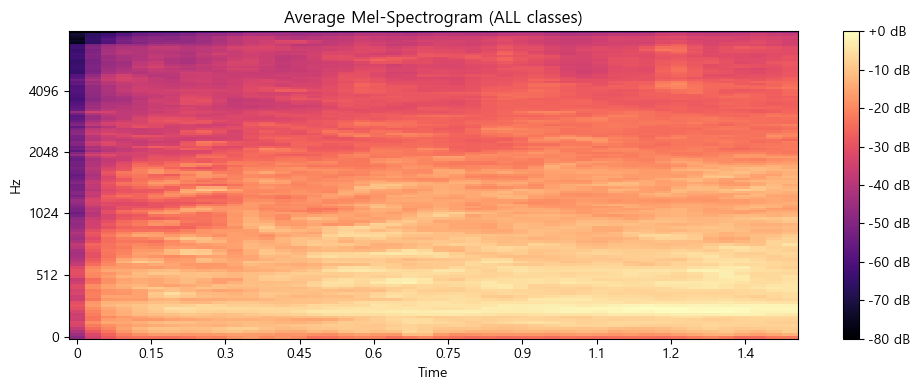

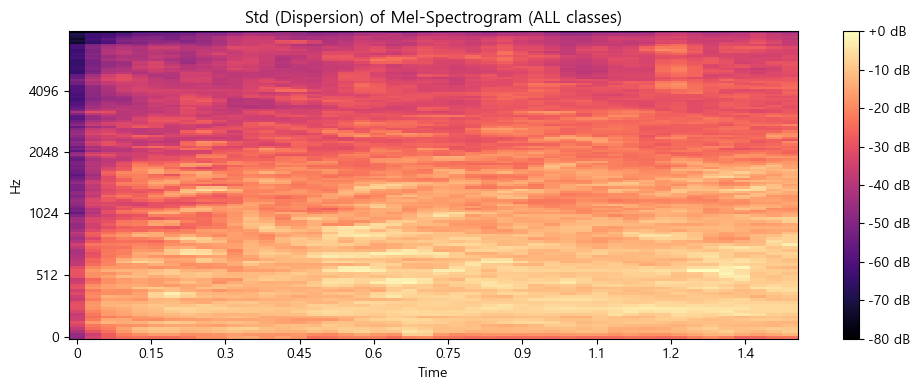

In [39]:
# Ïòà) Í∞êÏ†ïÎ≥ÑÎ°ú ÏµúÎåÄ 200Í∞úÏî© ÎΩëÏùÄ Îã§Ïùå Ï†ÑÏ≤¥Î•º ÌîåÎû´ÏúºÎ°ú Ìï©ÏπòÍ∏∞
emo_to_paths = pick_paths_by_class(clean_df, per_class=200, path_col="wav_path", label_col="final_emotion")
all_paths = flatten_paths(emo_to_paths)

mean_db_all, std_db_all = mean_std_from_paths(all_paths, sr=16000, n_mels=128, fixed_T=None, mode="truncate")

if mean_db_all is not None:
    plt.figure(figsize=(10,4))
    librosa.display.specshow(mean_db_all, sr=16000, x_axis='time', y_axis='mel')
    plt.title("Average Mel-Spectrogram (ALL classes)")
    plt.colorbar(format="%+2.f dB"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,4))
    librosa.display.specshow(std_db_all, sr=16000, x_axis='time', y_axis='mel')
    plt.title("Std (Dispersion) of Mel-Spectrogram (ALL classes)")
    plt.colorbar(format="%+2.f dB"); plt.tight_layout(); plt.show()


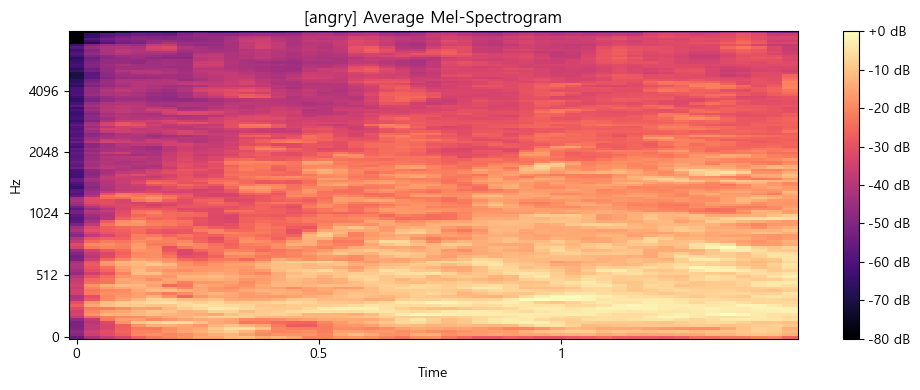

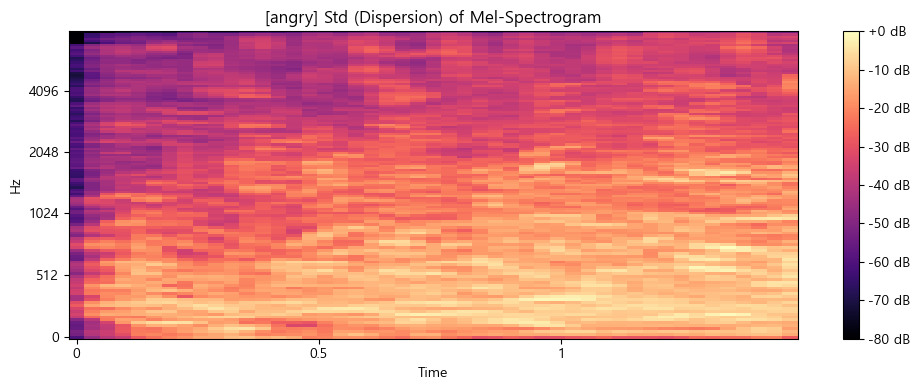

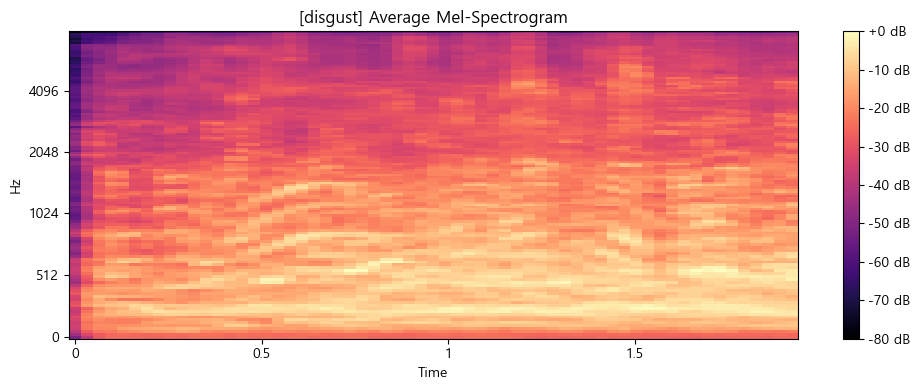

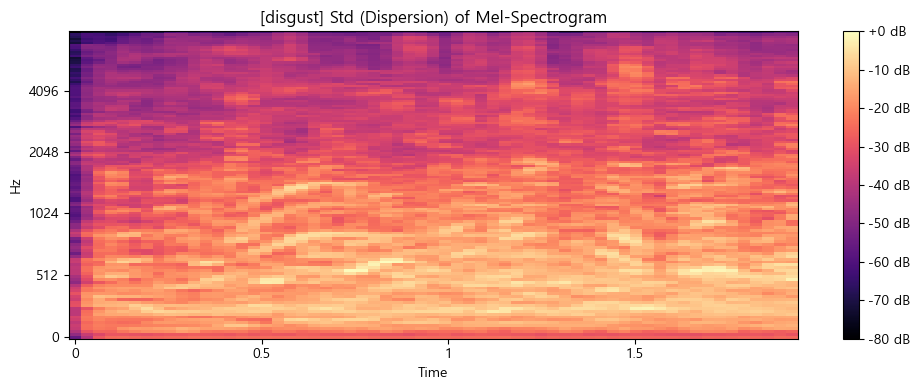

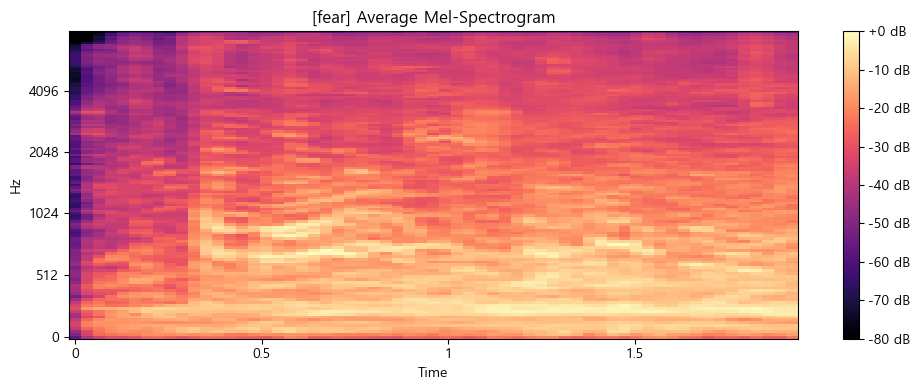

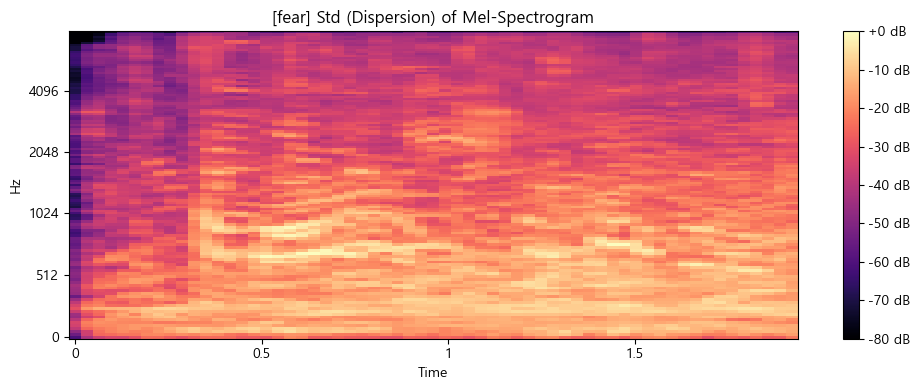

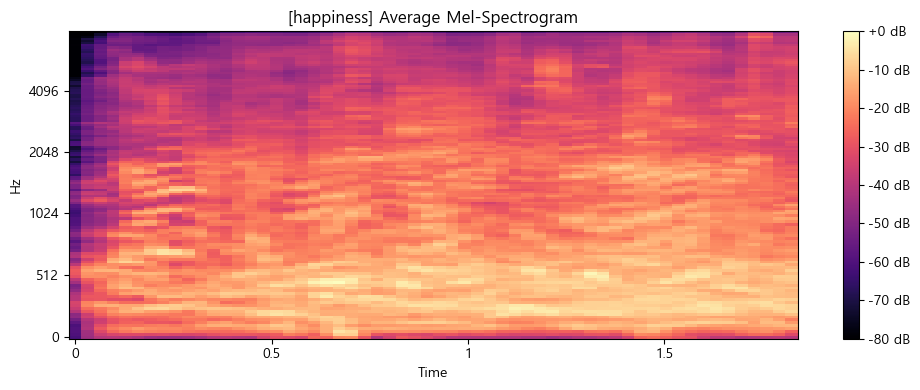

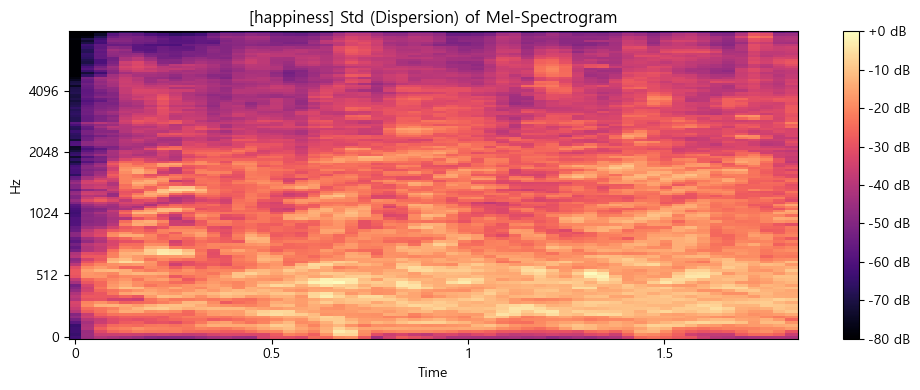

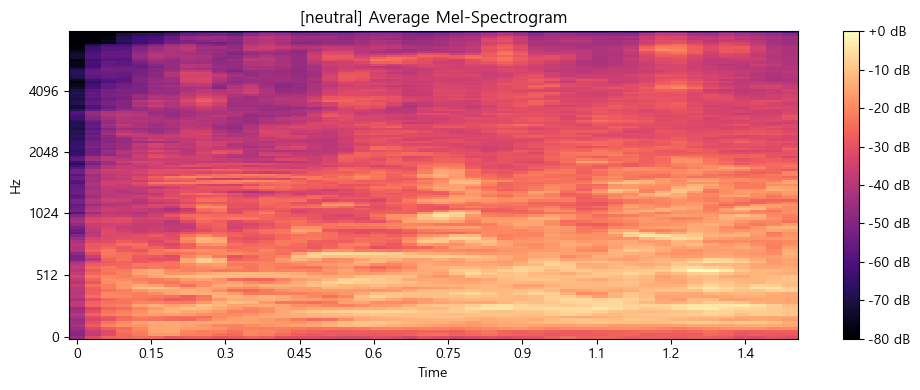

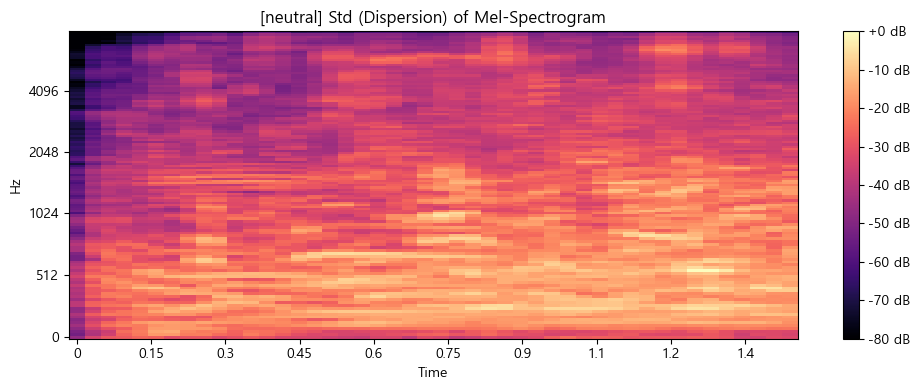

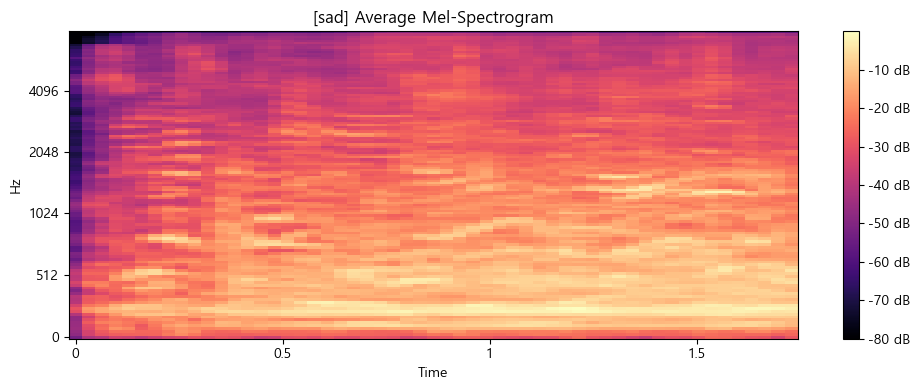

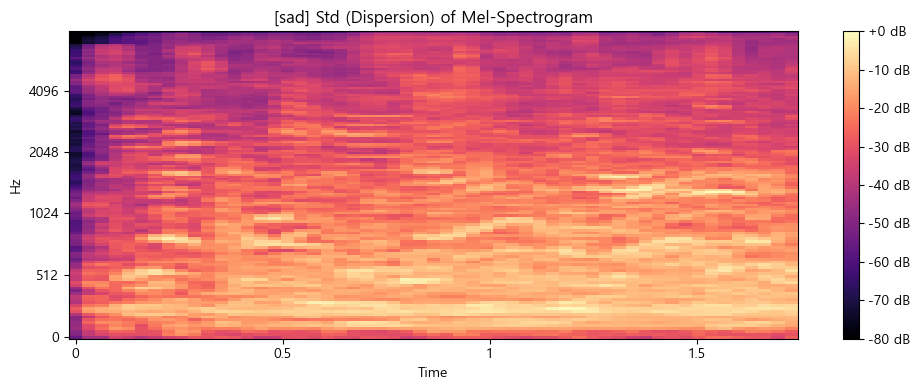

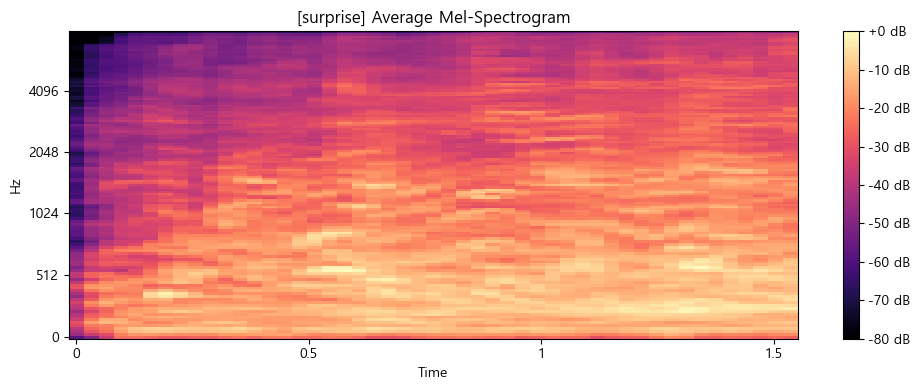

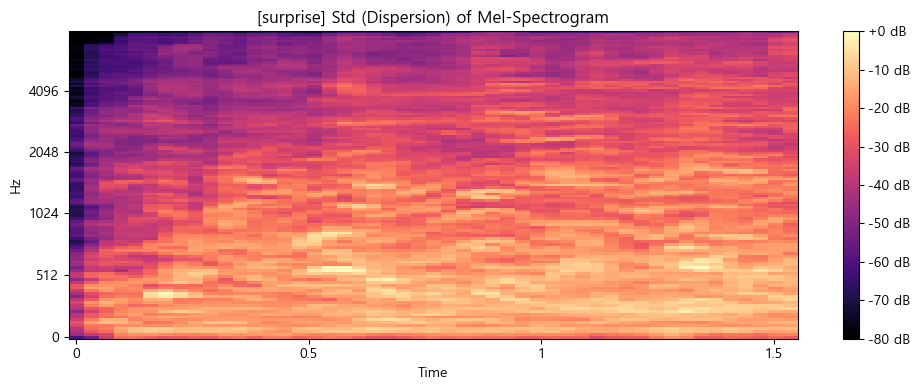

In [40]:
for emo in (EMO_ORDER if set(EMO_ORDER) <= set(emo_to_paths.keys()) else emo_to_paths.keys()):
    paths = emo_to_paths.get(emo, [])
    if not paths:
        continue
    mean_db, std_db = mean_std_from_paths(paths, sr=16000, n_mels=128, fixed_T=None, mode="truncate")
    if mean_db is None:
        continue

    plt.figure(figsize=(10,4))
    librosa.display.specshow(mean_db, sr=16000, x_axis='time', y_axis='mel')
    plt.title(f"[{emo}] Average Mel-Spectrogram")
    plt.colorbar(format="%+2.f dB"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,4))
    librosa.display.specshow(std_db, sr=16000, x_axis='time', y_axis='mel')
    plt.title(f"[{emo}] Std (Dispersion) of Mel-Spectrogram")
    plt.colorbar(format="%+2.f dB"); plt.tight_layout(); plt.show()


In [32]:
import os, numpy as np, pandas as pd
import librosa, librosa.feature, librosa.util

def compute_quality(y, sr):
    y = librosa.util.normalize(y, axis=0)  # Î†àÎ≤® ÌëúÏ§ÄÌôî(peak=1 Í∏∞Ï§Ä ÏïÑÎãò, Ïä§ÏºÄÏùº ÏïàÏ†ïÏö©)
    peak = float(np.max(np.abs(y)) + 1e-12)
    rms = float(np.sqrt(np.mean(y**2)) + 1e-12)
    crest = float(peak / rms)

    # clipping: Ï†ïÍ∑úÌôî Ïù¥ÌõÑÏóêÎèÑ ¬±0.99 Í∑ºÏ≤òÎ©¥ Ìè¨Ìôî Í∞ÄÎä•ÏÑ±
    clipping_ratio = float(np.mean(np.abs(y) >= 0.99))

    # DC offset
    dc_offset = float(np.mean(y))

    # ÌîÑÎ†àÏûÑ RMSÎ°ú Î¨¥Ïùå ÎπÑÏú®
    hop = int(0.010 * sr)  # 10ms
    frm = int(0.025 * sr)  # 25ms
    frame_rms = librosa.feature.rms(y=y, frame_length=frm, hop_length=hop)[0]
    thr = np.percentile(frame_rms, 20)  # ÌïòÏúÑ 20%Î•º Ï†ÄÏóêÎÑàÏßÄ Í∏∞Ï§ÄÏúºÎ°ú
    silence_ratio = float(np.mean(frame_rms < max(thr, 1e-6)))

    # Í∞ÑÏù¥ SNR: ÏïûÎí§ 0.3Ï¥àÎ•º noise, Ï§ëÏïô 0.6Ï¥àÎ•º speechÎ°ú Í∞ÄÏ†ï
    n_edge = int(0.3 * sr)
    if len(y) > 2 * n_edge:
        noise = np.concatenate([y[:n_edge], y[-n_edge:]])
        mid = y[n_edge:-n_edge]
    else:
        # Í∏∏Ïù¥Í∞Ä ÏßßÏúºÎ©¥ ÌïòÏúÑ 20% vs ÏÉÅÏúÑ 80% ÌîÑÎ†àÏûÑÏúºÎ°ú Í∑ºÏÇ¨
        idx = frame_rms.argsort()
        k = max(1, int(0.2 * len(idx)))
        noise = librosa.util.frame(y, frame_length=frm, hop_length=hop).T[idx[:k]].ravel()
        mid   = librosa.util.frame(y, frame_length=frm, hop_length=hop).T[idx[k:]].ravel()
    nrms = float(np.sqrt(np.mean(noise**2)) + 1e-12)
    srms = float(np.sqrt(np.mean(mid**2)) + 1e-12)
    snr_proxy_db = float(10 * np.log10((srms**2) / (nrms**2)))

    # Ïä§ÌéôÌä∏Îüº Í∏∞Î∞ò
    S = np.abs(librosa.stft(y, n_fft=1024, hop_length=hop))**2
    mel = librosa.feature.melspectrogram(S=S, sr=sr, n_mels=64, power=1.0)
    mel_norm = mel / (mel.sum(axis=0, keepdims=True) + 1e-12)

    # Í≥†Ï£ºÌåå ÎπÑÏú®(>6kHz)
    mel_f = librosa.mel_frequencies(n_mels=64, fmin=0, fmax=sr/2)
    hf_mask = mel_f >= 6000
    hf_ratio = float((mel_norm[hf_mask, :].sum()) / (mel_norm.sum() + 1e-12))

    # Ïä§ÌéôÌä∏Îü¥ Ï§ëÏã¨/ÎåÄÏó≠Ìè≠(ÌèâÍ∑†)
    centroid = librosa.feature.spectral_centroid(S=S, sr=sr)[0]
    bandwidth = librosa.feature.spectral_bandwidth(S=S, sr=sr)[0]
    centroid_mean = float(np.mean(centroid))
    bandwidth_mean = float(np.mean(bandwidth))

    return dict(
        peak=peak, rms=rms, crest=crest, clipping_ratio=clipping_ratio, dc_offset=dc_offset,
        silence_ratio=silence_ratio, snr_proxy_db=snr_proxy_db, hf_ratio=hf_ratio,
        centroid_mean=centroid_mean, bandwidth_mean=bandwidth_mean
    )

def quality_for_paths(paths, sr=16000, max_files=None):
    rows = []
    for i, p in enumerate(paths):
        if (max_files is not None) and (i >= max_files): break
        if not os.path.exists(p): continue
        try:
            y, _ = librosa.load(p, sr=sr)
            q = compute_quality(y, sr)
            q["wav_path"] = p
            rows.append(q)
        except Exception:
            continue
    return pd.DataFrame(rows)


In [ ]:
# Í∞êÏ†ïÎ≥ÑÎ°ú Í∑†Ìòï ÏÉòÌîå Ï∂îÏ∂ú (Ïù¥ÎØ∏ clean_dfÏóê wav_path, final_emotion Í∞ÄÏ†ï)
per_class = 50
emo2paths = {emo: grp["wav_path"].sample(min(per_class, len(grp))).tolist()
             for emo, grp in clean_df.groupby("final_emotion")}

# Ìï©ÏπòÍ∏∞
scan_paths = [p for paths in emo2paths.values() for p in paths]
qdf = quality_for_paths(scan_paths, sr=16000)

# Í∞êÏ†ï ÎùºÎ≤® Î∂ôÏù¥Í∏∞
emap = clean_df.set_index("wav_path")["final_emotion"].to_dict()
qdf["final_emotion"] = qdf["wav_path"].map(emap)

# ÌÅ¥ÎûòÏä§Î≥Ñ Ï§ëÏïôÍ∞í/Î∂ÑÏúÑÏàò ÏöîÏïΩ
summary = qdf.groupby("final_emotion").agg(
    n=("wav_path","count"),
    rms_med=("rms","median"),
    crest_med=("crest","median"),
    clip95=("clipping_ratio", lambda x: np.percentile(x,95)),
    dc_med=("dc_offset","median"),
    sil_med=("silence_ratio","median"),
    snr_med=("snr_proxy_db","median"),
    hf_med=("hf_ratio","median"),
).sort_values("n", ascending=False)
print(summary)


                n   rms_med  crest_med    clip95        dc_med   sil_med  \
final_emotion                                                              
angry          50  0.114388   8.742251  0.000038 -2.446472e-07  0.200264   
disgust        50  0.118949   8.407085  0.000036 -8.828809e-06  0.200355   
fear           50  0.124719   8.018072  0.000053 -5.359694e-06  0.200355   
happiness      50  0.118892   8.412872  0.000039 -8.678160e-06  0.200284   
neutral        50  0.097399  10.267085  0.000053 -1.729497e-05  0.200397   
sad            50  0.109997   9.091225  0.000034 -3.656144e-06  0.200370   
surprise       50  0.125456   7.971453  0.000077 -1.378907e-05  0.200349   

                 snr_med    hf_med  
final_emotion                       
angry          23.661125  0.009182  
disgust        21.528900  0.007543  
fear           22.922326  0.008310  
happiness      24.157196  0.014135  
neutral        24.094717  0.007599  
sad            19.840162  0.006993  
surprise       24.3

In [34]:
# Í∞ÑÎã® ÏûÑÍ≥ÑÍ∞í(Í≤ΩÌóòÏπô): ÌïÑÏöîÏóê Îî∞Îùº Ï°∞Ï†ï
CLIP_T = 0.01      # 1% Ïù¥ÏÉÅ Ìè¨Ìôî
CREST_T = 20.0     # Í≥ºÎèÑÌïú ÌÅ¨Î†àÏä§Ìä∏(Ïó∞Í∏∞ÌÜ§/Í≥ºÏû• Í∞ÄÎä•)
DC_T = 0.02        # DC Ïò§ÌîÑÏÖã
SIL_T = 0.6        # Î¨¥Ïùå Í≥ºÎã§
SNR_T = 5.0        # SNR ÎÇÆÏùå(Í∑ºÏÇ¨Ïπò)

flags = (
    (qdf["clipping_ratio"] > CLIP_T) |
    (qdf["crest"] > CREST_T) |
    (np.abs(qdf["dc_offset"]) > DC_T) |
    (qdf["silence_ratio"] > SIL_T) |
    (qdf["snr_proxy_db"] < SNR_T)
)
bad = qdf[flags].sort_values(["clipping_ratio","crest","silence_ratio"], ascending=False)
print("‚ö†Ô∏è ÌíàÏßà ÌîåÎûòÍ∑∏ ÏÉòÌîå ÏÉÅÏúÑ 20Í∞ú")
cols = ["final_emotion","wav_path","clipping_ratio","crest","snr_proxy_db","silence_ratio","dc_offset","hf_ratio"]
print(bad[cols].head(20))


‚ö†Ô∏è ÌíàÏßà ÌîåÎûòÍ∑∏ ÏÉòÌîå ÏÉÅÏúÑ 20Í∞ú
    final_emotion                                           wav_path  \
305      surprise  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   
273           sad  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   
101          fear  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   
219       neutral  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   
214       neutral  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   
291           sad  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   
327      surprise  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   
128          fear  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   
182     happiness  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   
94        disgust  D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...   
308      surprise  D:\ex

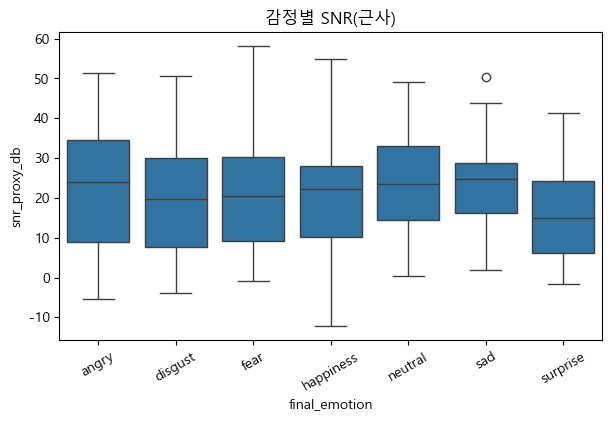

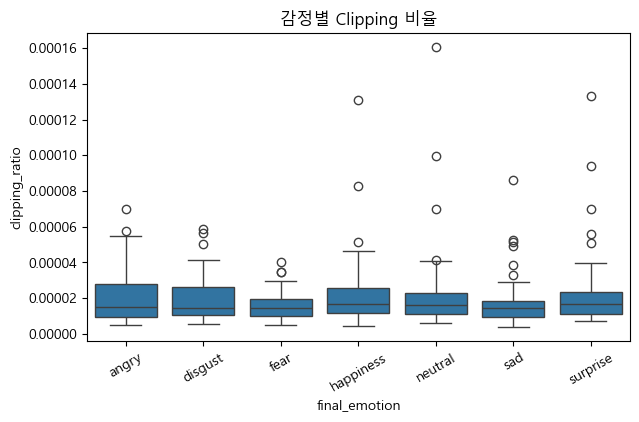

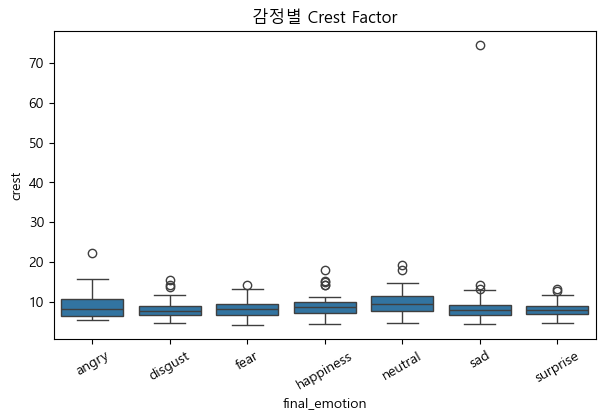

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))
sns.boxplot(x="final_emotion", y="snr_proxy_db", data=qdf)
plt.title("Í∞êÏ†ïÎ≥Ñ SNR(Í∑ºÏÇ¨)"); plt.xticks(rotation=30); plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(x="final_emotion", y="clipping_ratio", data=qdf)
plt.title("Í∞êÏ†ïÎ≥Ñ Clipping ÎπÑÏú®"); plt.xticks(rotation=30); plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(x="final_emotion", y="crest", data=qdf)
plt.title("Í∞êÏ†ïÎ≥Ñ Crest Factor"); plt.xticks(rotation=30); plt.show()


In [23]:
clean_df['wav_path']

0        D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...
1        D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...
2        D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...
3        D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...
4        D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...
                               ...                        
43986    D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...
43987    D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...
43988    D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...
43989    D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...
43990    D:\ex\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\AI_Dev_3rd_Project\YEO\datasets\Í∞ê...
Name: wav_path, Length: 42424, dtype: object

In [24]:
from pathlib import Path

# Í≤ΩÎ°ú Ï°¥Ïû¨ Ïó¨Î∂Ä Ï†êÍ≤Ä
paths = clean_df["wav_path"].astype(str).tolist()
exists_mask = [Path(p).exists() for p in paths]
print("Ï°¥Ïû¨:", sum(exists_mask), " / ÎàÑÎùΩ:", len(paths) - sum(exists_mask))

# ÎàÑÎùΩ ÏòàÏãú 5Í∞ú ÌôïÏù∏
missing = [p for p, ok in zip(paths, exists_mask) if not ok]
print("ÎàÑÎùΩ ÏòàÏãú:", missing[:5])


Ï°¥Ïû¨: 42408  / ÎàÑÎùΩ: 16
ÎàÑÎùΩ ÏòàÏãú: ['D:\\ex\\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\\AI_Dev_3rd_Project\\YEO\\datasets\\Í∞êÏ†ïÎ∂ÑÎ•òÎåÄÌôîÏùåÏÑ±\\Í∞êÏ†ï Î∂ÑÎ•òÎ•º ÏúÑÌïú ÎåÄÌôî ÏùåÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖã\\4Ï∞®\\5e2979c25807b852d9e018d5.wav', 'D:\\ex\\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\\AI_Dev_3rd_Project\\YEO\\datasets\\Í∞êÏ†ïÎ∂ÑÎ•òÎåÄÌôîÏùåÏÑ±\\Í∞êÏ†ï Î∂ÑÎ•òÎ•º ÏúÑÌïú ÎåÄÌôî ÏùåÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖã\\4Ï∞®\\5e298b9f5807b852d9e01a0f.wav', 'D:\\ex\\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\\AI_Dev_3rd_Project\\YEO\\datasets\\Í∞êÏ†ïÎ∂ÑÎ•òÎåÄÌôîÏùåÏÑ±\\Í∞êÏ†ï Î∂ÑÎ•òÎ•º ÏúÑÌïú ÎåÄÌôî ÏùåÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖã\\4Ï∞®\\5e298bc45807b852d9e01a10.wav', 'D:\\ex\\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\\AI_Dev_3rd_Project\\YEO\\datasets\\Í∞êÏ†ïÎ∂ÑÎ•òÎåÄÌôîÏùåÏÑ±\\Í∞êÏ†ï Î∂ÑÎ•òÎ•º ÏúÑÌïú ÎåÄÌôî ÏùåÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖã\\4Ï∞®\\5e298bdc5807b852d9e01a11.wav', 'D:\\ex\\ÏµúÏ¢ÖÌîÑÎ°úÏ†ùÌä∏\\AI_Dev_3rd_Project\\YEO\\datasets\\Í∞êÏ†ïÎ∂ÑÎ•òÎåÄÌôîÏùåÏÑ±\\Í∞êÏ†ï Î∂ÑÎ•òÎ•º ÏúÑÌïú ÎåÄÌôî ÏùåÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖã\\4Ï∞®\\5e298c085807b852d9e01a12.wav']


In [25]:
from pathlib import Path

# wav_path Ï°¥Ïû¨ Ïó¨Î∂Ä ÌôïÏù∏
clean_df["exists"] = clean_df["wav_path"].apply(lambda p: Path(str(p)).exists())

# ÎàÑÎùΩÎêú Í∞úÏàò ÌôïÏù∏
print("ÎàÑÎùΩÎêú ÏÉòÌîå Ïàò:", (~clean_df["exists"]).sum())

# ÏóÜÎäî ÌååÏùº ÎìúÎ°≠ ‚Üí ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã
final_df = clean_df[clean_df["exists"]].copy().reset_index(drop=True)

print("ÎìúÎ°≠ ÌõÑ Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞:", len(final_df))

ÎàÑÎùΩÎêú ÏÉòÌîå Ïàò: 16
ÎìúÎ°≠ ÌõÑ Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞: 42408


In [26]:
final_df.to_csv("clean_df_final.csv", index=False, encoding="utf-8-sig")

In [28]:
import torchaudio
# SR Î∂ÑÌè¨ ÌôïÏù∏
sr_counts = final_df["wav_path"].apply(lambda p: torchaudio.info(p).sample_rate).value_counts()
print(sr_counts)

# Î¶¨ÏÉòÌîåÎü¨ ÏòàÏãú(Í∞ÄÏßú ÏΩîÎìú; Ïã§Ï†úÎäî Dataset __getitem__ÏóêÏÑú Ï†ÅÏö©)
resampler = torchaudio.transforms.Resample(orig_freq=orig_sr, new_freq=16000)  # soxr ÏûàÏúºÎ©¥ soxr_vhq Í∂åÏû•
y16k = resampler(y)  # mono Î≥ÄÌôòÎèÑ Ìï®Íªò ÏàòÌñâ

wav_path
48000    42408
Name: count, dtype: int64


NameError: name 'orig_sr' is not defined

In [29]:
import torchaudio

# ÏòàÏãú: ÌååÏùº ÌïòÎÇò Î°úÎìú + Î¶¨ÏÉòÌîå
wav_path = final_df.iloc[0]["wav_path"]
y, sr = torchaudio.load(wav_path)   # sr == 48000
resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
y16k = resampler(y)  # shape: [channels, T']

print("before:", sr, "after:", 16000, "length:", y.shape[-1], "->", y16k.shape[-1])


before: 48000 after: 16000 length: 157696 -> 52566


In [44]:
import torchaudio
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

def compute_quality(path, target_sr=16000):
    try:
        # Î°úÎìú
        y, sr = torchaudio.load(path)
        if y.shape[0] > 1:
            y = torch.mean(y, dim=0, keepdim=True)
        y = y.squeeze().numpy()

        # Î¶¨ÏÉòÌîå ÌïÑÏöîÏãú
        if sr != target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

        # duration
        duration = len(y) / target_sr

        # RMS, Crest factor
        rms = np.sqrt(np.mean(y**2)) + 1e-8
        peak = np.max(np.abs(y))
        crest = peak / rms if rms > 0 else 0

        # clipping ratio (ÏûÑÍ≥ÑÏπò 0.99 Ïù¥ÏÉÅ)
        clip_ratio = np.mean(np.abs(y) >= 0.99)

        # DC offset
        dc_offset = np.mean(y)

        # Silence ratio (ÏÉòÌîå Ï§ë Ï†àÎåÄÍ∞í <0.001)
        silence_ratio = np.mean(np.abs(y) < 1e-3)

        # Í∑ºÏÇ¨ SNR: RMS / Î∞∞Í≤Ω ÎÖ∏Ïù¥Ï¶à(ÌïòÏúÑ 10% Ï†àÎåìÍ∞í)
        noise_floor = np.percentile(np.abs(y), 10)
        snr_proxy = 20 * np.log10(rms / (noise_floor + 1e-8))

        # High-frequency ratio (Îã®Ïàú Ïä§ÌéôÌä∏Îüº Î∂ÑÌè¨ Í∏∞Î∞ò)
        S = np.abs(librosa.stft(y, n_fft=512, hop_length=256))
        freqs = librosa.fft_frequencies(sr=target_sr, n_fft=512)
        hf_ratio = np.sum(S[freqs > 4000]) / np.sum(S)

        return {
            "wav_path": str(path),
            "duration": duration,
            "rms": rms,
            "crest": crest,
            "clipping_ratio": clip_ratio,
            "dc_offset": dc_offset,
            "silence_ratio": silence_ratio,
            "snr_proxy_db": snr_proxy,
            "hf_ratio": hf_ratio,
        }
    except Exception as e:
        return None

# ---- Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏÖãÏóê Ï†ÅÏö© ----
paths = final_df["wav_path"].tolist()
records = []

for p in tqdm(paths, desc="Computing quality metrics", unit="file"):
    q = compute_quality(p, target_sr=16000)
    if q is not None:
        records.append(q)

qdf = pd.DataFrame(records)
print("ÏôÑÎ£å! qdf ÌÅ¨Í∏∞:", len(qdf))


Computing quality metrics: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 42408/42408 [08:24<00:00, 84.03file/s] 


ÏôÑÎ£å! qdf ÌÅ¨Í∏∞: 42408


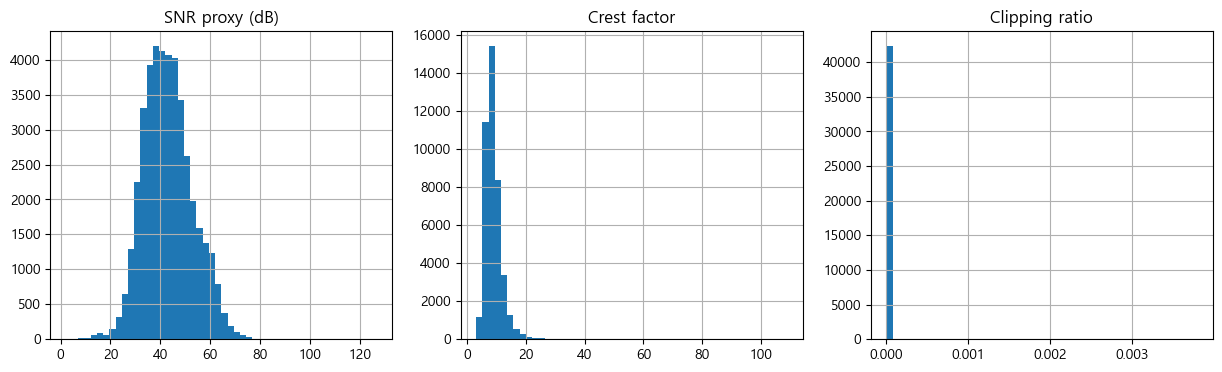

In [45]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15,4))

qdf["snr_proxy_db"].hist(bins=50, ax=axes[0])
axes[0].set_title("SNR proxy (dB)")

qdf["crest"].hist(bins=50, ax=axes[1])
axes[1].set_title("Crest factor")

qdf["clipping_ratio"].hist(bins=50, ax=axes[2])
axes[2].set_title("Clipping ratio")

plt.show()

In [49]:
clean_df.columns

Index(['wav_id', 'Î∞úÌôîÎ¨∏', 'ÏÉÅÌô©', '1Î≤à Í∞êÏ†ï', '1Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '2Î≤à Í∞êÏ†ï', '2Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '3Î≤à Í∞êÏ†ï',
       '3Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '4Î≤à Í∞êÏ†ï', '4Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '5Î≤à Í∞êÏ†ï', '5Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', 'ÎÇòÏù¥', 'ÏÑ±Î≥Ñ',
       'wav_path', 'wav_exists', 'duration', 'dataset_part', 'final_emotion',
       'tie_initial', 'tie_resolved_by_situation', 'utter_len',
       'agreement_ratio', 'agreement_count', 'voters_count', 'exists'],
      dtype='object')

In [51]:
final_df.columns

Index(['wav_id', 'Î∞úÌôîÎ¨∏', 'ÏÉÅÌô©', '1Î≤à Í∞êÏ†ï', '1Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '2Î≤à Í∞êÏ†ï', '2Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '3Î≤à Í∞êÏ†ï',
       '3Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '4Î≤à Í∞êÏ†ï', '4Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '5Î≤à Í∞êÏ†ï', '5Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', 'ÎÇòÏù¥', 'ÏÑ±Î≥Ñ',
       'wav_path', 'wav_exists', 'duration', 'dataset_part', 'final_emotion',
       'tie_initial', 'tie_resolved_by_situation', 'utter_len',
       'agreement_ratio', 'agreement_count', 'voters_count', 'exists'],
      dtype='object')

In [ ]:
# clean_dfÏôÄ qdf merge (ÎùºÎ≤® Ìè¨Ìï®ÎêòÎèÑÎ°ù!)
merged = final_df[["wav_path", "final_emotion", "agreement_ratio"]].merge(
    qdf[["wav_path","duration","snr_proxy_db","crest","clipping_ratio"]],
    on="wav_path", how="inner"
)


# ÌïÑÌÑ∞ÎßÅ Í∏∞Ï§Ä (Í∏∞Î≥∏Í∞í)
mask_all = (
    (merged["agreement_ratio"] >= 0.6) &
    (merged["duration"] >= 0.2) &
    (merged["snr_proxy_db"] >= 10) &        # ÏôÑÌôî: -inf~0 dB Ï†úÏô∏
    (merged["crest"] <= 30) &              # ÏôÑÌôî: Í∑πÎã® outlierÎßå Ï†úÏô∏
    (merged["clipping_ratio"] <= 0.01)     # ÏôÑÌôî: 5% Ïù¥ÏÉÅÎßå Ï†úÏô∏
)

filtered_df = merged[mask_all].copy()

print("ÏõêÎ≥∏:", len(final_df))
print("ÌïÑÌÑ∞ÎßÅ ÌõÑ:", len(filtered_df))
print("Ï†úÏô∏:", len(final_df)-len(filtered_df))

print("ÌïÑÌÑ∞ÎßÅ ÌõÑ ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨:")
print(filtered_df["final_emotion"].value_counts())


ÏõêÎ≥∏: 42408
ÌïÑÌÑ∞ÎßÅ ÌõÑ: 36500
Ï†úÏô∏: 5908
ÌïÑÌÑ∞ÎßÅ ÌõÑ ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨:
final_emotion
sad          15419
angry         6914
neutral       5438
happiness     3457
fear          2455
disgust       2091
surprise       726
Name: count, dtype: int64


In [41]:
merged.columns

Index(['wav_id', 'Î∞úÌôîÎ¨∏', 'ÏÉÅÌô©', '1Î≤à Í∞êÏ†ï', '1Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '2Î≤à Í∞êÏ†ï', '2Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '3Î≤à Í∞êÏ†ï',
       '3Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '4Î≤à Í∞êÏ†ï', '4Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', '5Î≤à Í∞êÏ†ï', '5Î≤à Í∞êÏ†ïÏÑ∏Í∏∞', 'ÎÇòÏù¥', 'ÏÑ±Î≥Ñ',
       'wav_path', 'wav_exists', 'duration', 'dataset_part', 'final_emotion_x',
       'tie_initial', 'tie_resolved_by_situation', 'utter_len',
       'agreement_ratio', 'agreement_count', 'voters_count', 'exists', 'peak',
       'rms', 'crest', 'clipping_ratio', 'dc_offset', 'silence_ratio',
       'snr_proxy_db', 'hf_ratio', 'centroid_mean', 'bandwidth_mean',
       'final_emotion_y'],
      dtype='object')